In [1]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.utils import save_image, make_grid

import math


In [2]:
dev = torch.device('cuda' if torch.cuda.is_available else 'cpu')
dev

device(type='cuda')

In [3]:
def draw_data(data, title_str='Data'):
    # function for scattering data

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(5,5))

    # Scatter data points in 2-dimensional space
    ax.scatter(data[:,0], data[:,1], label='data', c='red', alpha=.3)
    # set a title and labels
    ax.set_title(title_str)
    ax.legend()

In [4]:
def draw_datas(data_0, data_1, title_str='Data'):
    # function for scattering data

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(5,5))

    # Scatter data points in 2-dimensional space
    ax.scatter(data_0[:,0], data_0[:,1], label='x_t-1', c='red', alpha=.5)
    ax.scatter(data_1[:,0], data_1[:,1], label='x_t', c='blue', alpha=.5)

    # Draw arrows
    X = data_0[:,0]
    Y = data_0[:,1]

    v = data_1 - data_0
    v_x = v[:, 0]
    v_y = v[:, 1]

    plt.quiver(X, Y, v_x, v_y, color="blue", angles='xy', scale_units='xy', scale=1, alpha=.7)
    # plt.quiver(X, Y, v_x, v_y, color="b", scale_units='xy', scale=1, alpha=.7)
    # for x, y, x_new, y_new in zip(X, Y, X_new, Y_new):
    #   plt.annotate('', xy=(x_new, y_new), xytext=(x, y), arrowprops={"facecolor": "orange", "mutation_scale" : 0.5})

    # set a title and labels
    ax.set_title(title_str)
    plt.grid()
    ax.legend()

In [5]:
def draw_vector_field(points, vectors, title_str="vector field"):
    fig, ax = plt.subplots(figsize=(5, 5))

    x = points[:,0]
    y = points[:,1]
    x_v = vectors[:,0]
    y_v = vectors[:,1]

    plt.quiver(x, y, x_v, y_v, color="blue", angles='xy', scale_units='xy', scale=1, alpha=.7)

    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)

    ax.set_title(title_str)
    plt.grid()


In [6]:
class diffuse(nn.Module):
    def __init__(self, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(diffuse, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, data, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        # n, d = x0.shape
        # a_bar = self.alpha_bars[t]

        # if eta is None:
        #     eta = torch.randn(n, d).to(self.device)

        # noisy = a_bar.sqrt().reshape(n, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1) * eta

        # x_t-1 -> x_t
        data = data.to(self.device)
        n, d = data.shape
        beta = self.betas[t].to(self.device)

        if eta is None:
            eta = torch.randn(n, d).to(self.device)

        noisy = (1-beta).sqrt().view(-1, 1) * data + beta.sqrt().view(-1, 1) * eta
        return noisy

In [7]:
# Defining model
n_steps, min_beta, max_beta = 10, 10 ** -4, 0.02
input_dim=2
output_dim=2

m = diffuse(n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=dev)


In [8]:
def training_diffusive_flow(diffuse, data, n_epochs, device, lim=10, display=False, store_path="diffusive_flow.pt"):
  # flow_mean = torch.zeros(2, device=device)

  x_t_1 = data.to(device)
  # for epoch in range(n_epochs):
  eta = torch.randn_like(data).to(device)
  for t in range(diffuse.n_steps):
    noisy_data = m(x_t_1, t, eta)

    vector_field = noisy_data - x_t_1

    # draw_vector_field(x_t_1.cpu(), vector_field.cpu())

    x_t_1 = noisy_data

  flow = noisy_data.to(device) - data.to(device)
  
  draw_datas(data.cpu(), noisy_data.cpu(), title_str='Data & noisy_Data')
  plt.xlim(-lim, lim)
  plt.ylim(-lim, lim)
  
  draw_vector_field(data.cpu(), flow.cpu())
  plt.xlim(-lim, lim)
  plt.ylim(-lim, lim)
  # draw_data(flow.cpu(), "flow")
  # flow_mean += torch.mean(flow, dim=0)

  # flow_mean /= n_epochs

  # return flow_mean

# Gaussian data(1)

In [9]:
# generate a Gaussian data
dim = 2
datanum = 50
mean = np.array([0, 0])
cov = np.array([[.1,.02],[.02,.1]])

data = np.random.multivariate_normal(mean, cov, datanum)
data = torch.from_numpy(data)

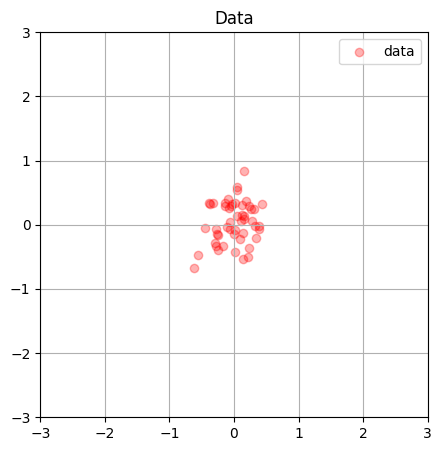

In [10]:
draw_data(data.cpu(), title_str='Data')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)

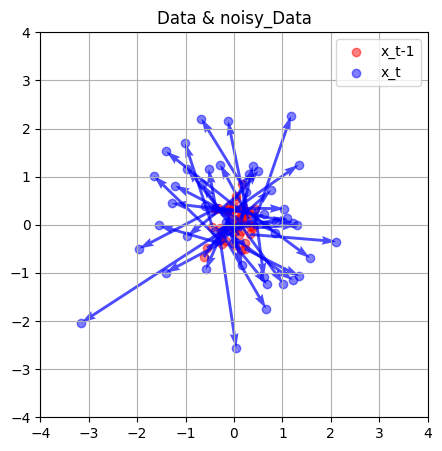

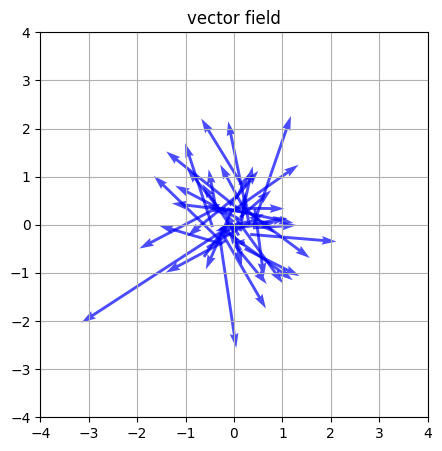

In [11]:
n_epochs = 10
flow_mean = [0.0, 0.0]
# flows = torch.
lim = 4


training_diffusive_flow(m, data, n_epochs, dev, lim, True)
# print("flow mean: {}".format(flow_mean))


# Gaussian data (2)

In [12]:
# generate a Gaussian data
dim = 2
datanum = 50
mean = np.array([2.5, 0.0])
cov = np.array([[.1,.02],[.02,5]])

data = np.random.multivariate_normal(mean, cov, datanum)
data = torch.from_numpy(data)

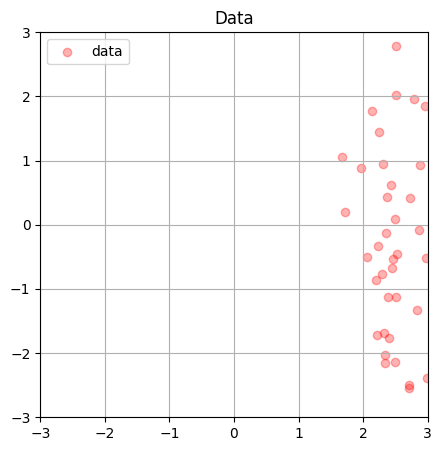

In [13]:
draw_data(data.cpu(), title_str='Data')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)